In [71]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
from scipy import stats
import geopandas as gpd
import plotly.express as px
import nbformat
import ipywidgets as widgets
from IPython.display import display, clear_output

In [72]:
# Step 1: Load data from cvs file exported from Resources/Wine_Country_Weather_Data_adj.xlsx
wine_data_df = pd.read_csv('Resources/Wine_data_all_2.csv')

# show the table to verify formatting
wine_data_df.head()

,Continent,country,Product,Variable,Year,Unit,Quantity
0,Asia,Afghanistan,Wine,Consumption,1995,1000 hl,0
1,Asia,Afghanistan,Wine,Imports,1995,1000 hl,0
2,Asia,Afghanistan,Wine,Production,1995,1000 hl,0
3,Asia,Afghanistan,Wine,Consumption,1996,1000 hl,0
4,Asia,Afghanistan,Wine,Imports,1996,1000 hl,0


In [73]:
# Get the country codes according to FIPS-10 standard
# This is the cleaned CSV with Country names that match with Wine data
country_codes_df = pd.read_csv('Resources/fips-countries.csv')
country_codes_df.head()

,code,country
0,AF,Afghanistan
1,AL,Albania
2,AG,Algeria
3,AQ,American Samoa
4,AN,Andorra


In [74]:
# Merge the wine data with country codes to get a column with matching 2 letter FIPS-10 country code
# This will allow us to correlate the data with NOAA weather data processed above into weather_country_overall_df
wine_data_df = pd.merge(wine_data_df, country_codes_df, on='country')
wine_data_df.head()


,Continent,country,Product,Variable,Year,Unit,Quantity,code
0,Asia,Afghanistan,Wine,Consumption,1995,1000 hl,0,AF
1,Asia,Afghanistan,Wine,Imports,1995,1000 hl,0,AF
2,Asia,Afghanistan,Wine,Production,1995,1000 hl,0,AF
3,Asia,Afghanistan,Wine,Consumption,1996,1000 hl,0,AF
4,Asia,Afghanistan,Wine,Imports,1996,1000 hl,0,AF


In [75]:
# Filter only production data
wine_data_df = wine_data_df[wine_data_df['Variable'] == 'Production']

# Filter only wine data
wine_data_df = wine_data_df[wine_data_df['Product'] == 'Wine']

# Trim unnecessary 'Variable' column
wine_data_df = wine_data_df.drop(columns=['Variable'])

# Clean up the Quantity column to replace spaces and convert to numeric
wine_data_df['Quantity'] = wine_data_df['Quantity'].str.replace(' ', '')
wine_data_df['Quantity'] = pd.to_numeric(wine_data_df['Quantity'])

# Convert 1000 HL to Gallons
wine_data_df['Gallons'] = wine_data_df['Quantity'] * 26417.2

# Drop unnecessary columns
wine_data_df = wine_data_df.drop(columns=['Quantity'])
wine_data_df = wine_data_df.drop(columns=['Continent'])
wine_data_df = wine_data_df.drop(columns=['Product'])

# Save the cleaned and grouped data to a new CSV file if needed
wine_data_df_path = 'Resources/Wine_data_all_update_codes.csv'
wine_data_df.to_csv(wine_data_df_path, index=False)
wine_data_df

,country,Year,Unit,code,Gallons
2,Afghanistan,1995,1000 hl,AF,0.0
5,Afghanistan,1996,1000 hl,AF,0.0
8,Afghanistan,1997,1000 hl,AF,0.0
11,Afghanistan,1998,1000 hl,AF,0.0
14,Afghanistan,1999,1000 hl,AF,0.0
...,...,...,...,...,...
21670,Zimbabwe,2018,1000 hl,ZI,528344.0
21674,Zimbabwe,2019,1000 hl,ZI,369840.8
21678,Zimbabwe,2020,1000 hl,ZI,369840.8
21682,Zimbabwe,2021,1000 hl,ZI,369840.8


## Clean and pivot climate data tables to one record for each station / year

In [76]:
# Load the Weather Data
file_path = 'Resources/weather_all_country_codes3.csv'
df = pd.read_csv(file_path)

# Pivot the Weather DataFrame
pivoted_df = df.pivot_table(index=['station', 'date'], columns='datatype', values='value').reset_index()


# Load the Station Codes Data
column_names = ['station_id', 'latitude', 'longitude', 'elevation', 'location']
colspecs = [(0, 11), (12, 20), (21, 30), (31, 37), (38, None)]
file_path_txt = 'Resources/stationcodes.txt'
df_station_codes = pd.read_fwf(file_path_txt, colspecs=colspecs, header=None, names=column_names)


# Rename Columns for Merging
df_station_codes.rename(columns={'station_id': 'station'}, inplace=True)
df_station_codes.rename(columns={'country': 'code'}, inplace=True)

# Clean Column Names
pivoted_df.columns = pivoted_df.columns.str.strip()
df_station_codes.columns = df_station_codes.columns.str.strip()

# Remove the 'GHCND:' prefix from the 'station' column in both DataFrames
pivoted_df['station'] = pivoted_df['station'].str.replace('GHCND:', '')
df_station_codes['station'] = df_station_codes['station'].str.replace('GHCND:', '')


# Update the 'code' values
pivoted_df['code'] = pivoted_df['station'].str[:2]

# Merge the DataFrames to add Lat, Long to weather data
merged_df = pd.merge(pivoted_df, df_station_codes, on='station', how='left')

# Export the merged DataFrame to a CSV file
output_file_path = 'Resources/merged_weather_data.csv'
merged_df.to_csv(output_file_path, index=False)
print(f"Merged DataFrame exported to {output_file_path}")
merged_df




Merged DataFrame exported to Resources/merged_weather_data.csv


,station,date,DP10,DP1X,DT32,DX70,DX90,EMNT,EMXP,EMXT,...,MNPN,MXPN,PRCP,TAVG,TMAX,code,latitude,longitude,elevation,location
0,AE000041196,2012-01-01T00:00:00,NaN,NaN,NaN,346.0,226.0,NaN,NaN,121.0,...,NaN,NaN,NaN,NaN,96.0,AE,25.333,55.517,34.0,SHARJAH INTER. AIRP GSN 41196
1,AE000041196,2023-01-01T00:00:00,8.0,1.0,NaN,NaN,NaN,NaN,1.06,NaN,...,NaN,NaN,3.42,NaN,NaN,AE,25.333,55.517,34.0,SHARJAH INTER. AIRP GSN 41196
2,AEM00041194,2004-01-01T00:00:00,4.0,0.0,NaN,NaN,NaN,NaN,0.90,NaN,...,NaN,NaN,2.31,NaN,NaN,AE,25.255,55.364,10.4,DUBAI INTL 41194
3,AEM00041194,2006-01-01T00:00:00,7.0,1.0,NaN,NaN,NaN,NaN,1.77,NaN,...,NaN,NaN,4.08,NaN,NaN,AE,25.255,55.364,10.4,DUBAI INTL 41194
4,AEM00041194,2010-01-01T00:00:00,5.0,1.0,NaN,NaN,NaN,NaN,3.15,NaN,...,NaN,NaN,4.83,NaN,NaN,AE,25.255,55.364,10.4,DUBAI INTL 41194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31219,WA010101860,2003-01-01T00:00:00,35.0,0.0,0.0,348.0,117.0,38.0,0.87,100.0,...,NaN,NaN,12.60,72.3,85.5,WA,-19.600,18.117,1400.0,GROOTFONTEIN GSN 68014
31220,WA010101860,2022-01-01T00:00:00,NaN,NaN,NaN,348.0,126.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,86.5,WA,-19.600,18.117,1400.0,GROOTFONTEIN GSN 68014
31221,WA012084750,1998-01-01T00:00:00,NaN,NaN,NaN,340.0,210.0,NaN,NaN,103.0,...,NaN,NaN,NaN,NaN,90.7,WA,-17.917,19.767,1100.0,RUNDU 68018
31222,WA012084750,1999-01-01T00:00:00,NaN,NaN,NaN,343.0,132.0,NaN,NaN,102.0,...,NaN,NaN,NaN,NaN,88.3,WA,-17.917,19.767,1100.0,RUNDU 68018


# Begin Spatial analysis of wine regions to weather stations

                      name     latitude     longitude  \
0           AOC Haut-M̩doc  45.22208291  -0.898633072   
1              AOC Ajaccio  41.88872288   8.804930084   
2  DOC Costa d&apos;Amalfi   40.6214488   14.57208446   
3            AOC Hermitage  45.07462896   4.837683076   
4               AOC Alsace  48.66041665   7.659245758   

                    geometry  
0  POINT (-0.89863 45.22208)  
1   POINT (8.80493 41.88872)  
2  POINT (14.57208 40.62145)  
3   POINT (4.83768 45.07463)  
4   POINT (7.65925 48.66042)  


<Axes: >

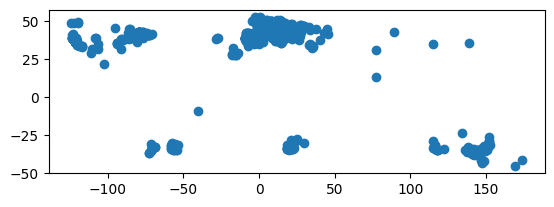

In [77]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union

# Load the shapefile
shapefile_path = 'Resources/Shapefiles/GlobalVineyards.shp'
gdf_shape = gpd.read_file(shapefile_path)

# Ensure the shapefile uses the same coordinate system as the weather data
gdf_shape = gdf_shape.to_crs(epsg=4326)

# Display the first few rows of the GeoDataFrame
print(gdf_shape.head())

# Plot the shapefile
gdf_shape.plot()


In [78]:

# Check for stations that did not get lat and long coordinates
stations_df = merged_df.dropna(subset=['latitude', 'longitude'])  # Drop rows with missing coordinates

# Create a GeoDataFrame from the weather station DataFrame
geometry = [Point(xy) for xy in zip(stations_df['longitude'], stations_df['latitude'])]
gdf_stations = gpd.GeoDataFrame(stations_df, geometry=geometry)

# Ensure the GeoDataFrame uses the same coordinate system
gdf_stations.crs = "EPSG:4326"

# Re-project both GeoDataFrames to a projected CRS suitable for distance calculations
projected_crs = "EPSG:3395"  # World Mercator projection
gdf_shape = gdf_shape.to_crs(projected_crs)
gdf_stations = gdf_stations.to_crs(projected_crs)

# Convert distance to meters (100 miles is approximately 160934 meters)
buffer_distance = 160934  # 100 miles in meters

# Create a buffer around the shapefile geometries
shape_buffer = gdf_shape.geometry.buffer(buffer_distance)

# Combine all buffered shapes into a single geometry
combined_shape_buffer = unary_union(shape_buffer)

# Find weather stations within the buffer
stations_within_buffer = gdf_stations[gdf_stations.geometry.within(combined_shape_buffer)]

# Display the results
print(stations_within_buffer)

# Optionally, save the results to a new CSV file
output_file_path = 'Resources/stations_within_100_miles.csv'
stations_within_buffer.to_csv(output_file_path, index=False)
print(f"Stations within 100 miles exported to {output_file_path}")

# Re-project back to geographic CRS for plotting
stations_within_buffer = stations_within_buffer.to_crs(epsg=4326)
shape_buffer_geo = gpd.GeoSeries([combined_shape_buffer], crs=projected_crs).to_crs(epsg=4326)

# Display the results
stations_within_buffer


           station                 date  DP10  DP1X  DT32   DX70  DX90  EMNT  \
16     AG000060390  1995-01-01T00:00:00  40.0   4.0   3.0  239.0  27.0  31.0   
17     AG000060390  1996-01-01T00:00:00  59.0   6.0   2.0  228.0  21.0  29.0   
18     AG000060390  1997-01-01T00:00:00  44.0   5.0   0.0  231.0  20.0  33.0   
19     AG000060390  1998-01-01T00:00:00  47.0   6.0   4.0  220.0  30.0  30.0   
20     AG000060390  2004-01-01T00:00:00  51.0   8.0   NaN    NaN   NaN   NaN   
...            ...                  ...   ...   ...   ...    ...   ...   ...   
30213  UYM00086580  2016-01-01T00:00:00  58.0  13.0   NaN    NaN   NaN   NaN   
30214  UYM00086580  2017-01-01T00:00:00  62.0  18.0   NaN    NaN   NaN   NaN   
30215  UYM00086580  2018-01-01T00:00:00  68.0  15.0   NaN    NaN   NaN   NaN   
30216  UYM00086580  2019-01-01T00:00:00  62.0  16.0   NaN    NaN   NaN   NaN   
30217  UYM00086580  2022-01-01T00:00:00  49.0   7.0   NaN    NaN   NaN   NaN   

       EMXP   EMXT  ...  MXPN   PRCP  T

,station,date,DP10,DP1X,DT32,DX70,DX90,EMNT,EMXP,EMXT,...,MXPN,PRCP,TAVG,TMAX,code,latitude,longitude,elevation,location,geometry
16,AG000060390,1995-01-01T00:00:00,40.0,4.0,3.0,239.0,27.0,31.0,1.60,105.0,...,NaN,21.72,64.5,75.5,AG,36.7167,3.250,24.0,ALGER-DAR EL BEIDA GSN 60390,POINT (3.25000 36.71670)
17,AG000060390,1996-01-01T00:00:00,59.0,6.0,2.0,228.0,21.0,29.0,2.56,113.0,...,NaN,31.57,63.6,73.5,AG,36.7167,3.250,24.0,ALGER-DAR EL BEIDA GSN 60390,POINT (3.25000 36.71670)
18,AG000060390,1997-01-01T00:00:00,44.0,5.0,0.0,231.0,20.0,33.0,2.08,101.0,...,NaN,21.52,65.0,75.4,AG,36.7167,3.250,24.0,ALGER-DAR EL BEIDA GSN 60390,POINT (3.25000 36.71670)
19,AG000060390,1998-01-01T00:00:00,47.0,6.0,4.0,220.0,30.0,30.0,1.92,104.0,...,NaN,23.99,63.7,74.8,AG,36.7167,3.250,24.0,ALGER-DAR EL BEIDA GSN 60390,POINT (3.25000 36.71670)
20,AG000060390,2004-01-01T00:00:00,51.0,8.0,NaN,NaN,NaN,NaN,1.85,NaN,...,NaN,25.31,NaN,NaN,AG,36.7167,3.250,24.0,ALGER-DAR EL BEIDA GSN 60390,POINT (3.25000 36.71670)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30213,UYM00086580,2016-01-01T00:00:00,58.0,13.0,NaN,NaN,NaN,NaN,3.76,NaN,...,NaN,44.57,NaN,NaN,UY,-34.8380,-56.031,32.0,CARRASCO INTL 86580,POINT (-56.03100 -34.83800)
30214,UYM00086580,2017-01-01T00:00:00,62.0,18.0,NaN,NaN,NaN,NaN,6.44,NaN,...,NaN,57.66,NaN,NaN,UY,-34.8380,-56.031,32.0,CARRASCO INTL 86580,POINT (-56.03100 -34.83800)
30215,UYM00086580,2018-01-01T00:00:00,68.0,15.0,NaN,NaN,NaN,NaN,7.01,NaN,...,NaN,58.26,NaN,NaN,UY,-34.8380,-56.031,32.0,CARRASCO INTL 86580,POINT (-56.03100 -34.83800)
30216,UYM00086580,2019-01-01T00:00:00,62.0,16.0,NaN,NaN,NaN,NaN,3.07,NaN,...,NaN,47.50,NaN,NaN,UY,-34.8380,-56.031,32.0,CARRASCO INTL 86580,POINT (-56.03100 -34.83800)


# Plot stations within wine regions

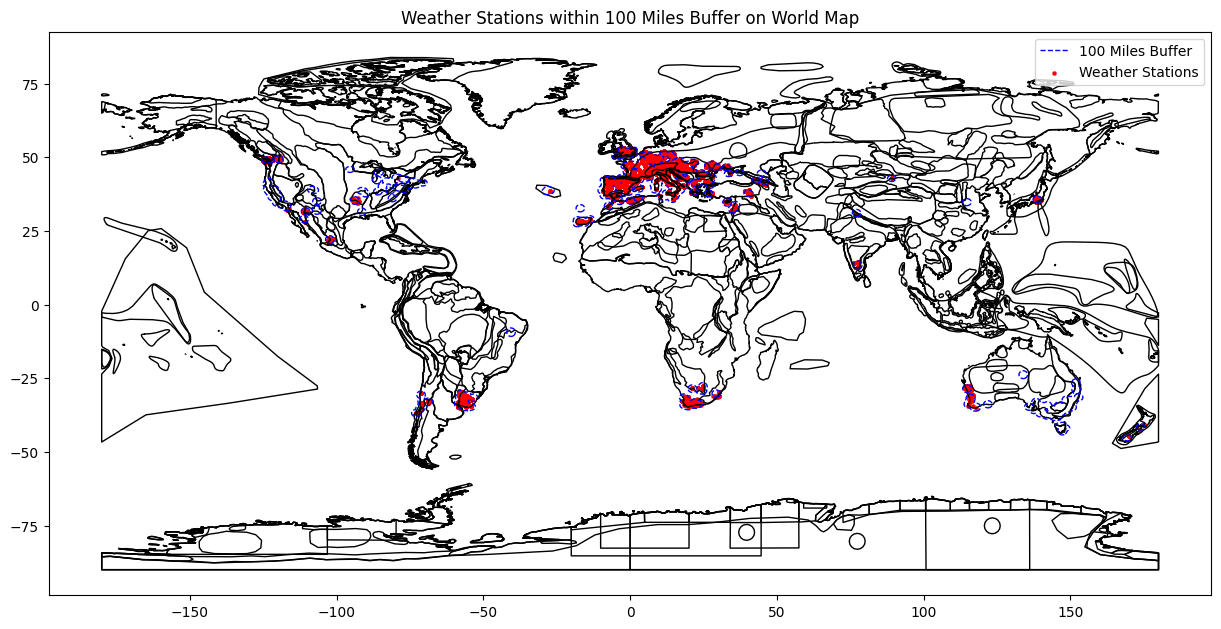

In [79]:
# Load a world map
# Load the world map from Natural Earth dataset
world_shapefile_path = 'Resources/Shapefiles/ne_50m_geography_regions_polys.shp'
world = gpd.read_file(world_shapefile_path)

# Plot the world map, buffer, and stations within the buffer
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1, color='black')
shape_buffer_geo.boundary.plot(ax=ax, color='blue', linewidth=1, linestyle='--', label='100 Miles Buffer')
stations_within_buffer.plot(ax=ax, color='red', markersize=5, label='Weather Stations')

plt.title('Weather Stations within 100 Miles Buffer on World Map')
plt.legend()
plt.show()


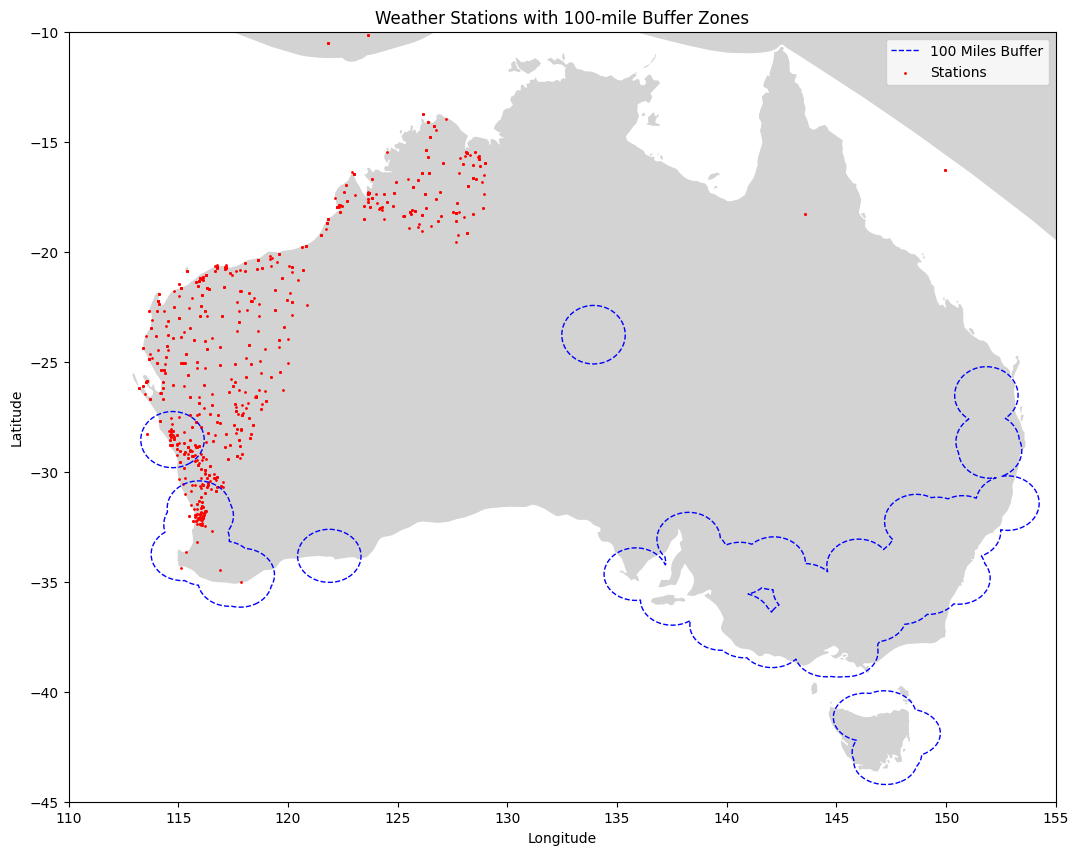

In [80]:
#What is the deal with Australia weather stations? Are there really no data stations for the south east of Australia?

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(merged_df['longitude'], merged_df['latitude'])]
gdf = gpd.GeoDataFrame(merged_df, geometry=geometry)

# Set the CRS to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

world_shapefile_path = 'Resources/Shapefiles/ne_50m_geography_regions_polys.shp'
world = gpd.read_file(world_shapefile_path)

# Plot the world map, buffer, and stations within the buffer
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgray')
shape_buffer_geo.boundary.plot(ax=ax, color='blue', linewidth=1, linestyle='--', label='100 Miles Buffer')

# Plot the stations
gdf.plot(ax=ax, color='red', markersize=1, label='Stations')


# Set the limits to zoom in on Australia
ax.set_xlim(110, 155)
ax.set_ylim(-45, -10)

# Add legend and title
plt.legend()
plt.title('Weather Stations with 100-mile Buffer Zones')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [81]:
#Double checking my new start file matches up with original start file

import pandas as pd

# Load the weather_all_country_codes3.csv file
weather_file_path = 'Resources/weather_all_country_codes3.csv'
weather_df = pd.read_csv(weather_file_path)

# Load the merged_weather_data.csv file
merged_file_path = 'Resources/merged_weather_data.csv'
merged_df = pd.read_csv(merged_file_path)

# Ensure the station identifiers are consistent (e.g., remove 'GHCND:' prefix if necessary)
weather_df['station'] = weather_df['station'].str.replace('GHCND:', '')
merged_df['station'] = merged_df['station'].str.replace('GHCND:', '')

# Calculate the number of unique station IDs in each file
unique_stations_weather = weather_df['station'].nunique()
unique_stations_merged = merged_df['station'].nunique()

print(f"Number of unique stations in weather_all_country_codes3.csv: {unique_stations_weather}")
print(f"Number of unique stations in merged_weather_data.csv: {unique_stations_merged}")


Number of unique stations in weather_all_country_codes3.csv: 6303
Number of unique stations in merged_weather_data.csv: 6303


In [82]:
#Checking to see if eliminated any countries that should not have been by using the regions Then added back in country data

# Load the merged weather station file
merged_file_path = 'Resources/merged_weather_data.csv'
merged_df = pd.read_csv(merged_file_path)

# Load the stations_within_buffer file
stations_within_buffer_file_path = 'Resources/stations_within_100_miles.csv'  # Update this path
stations_within_buffer = pd.read_csv(stations_within_buffer_file_path)

# Load the country codes file
country_codes_file_path = 'Resources/ghcnd-countries.csv'  # Update this path
country_codes_df = pd.read_csv(country_codes_file_path)

# Load the wine data file
wine_data_file_path = 'Resources/Wine_data_all_update_codes.csv'
wine_df = pd.read_csv(wine_data_file_path)

# Extract unique country codes
unique_country_codes_merged = set(merged_df['code'].unique())
unique_country_codes_buffer = set(stations_within_buffer['code'].unique())

# Find country codes in merged_df but not in stations_within_buffer
missing_country_codes = unique_country_codes_merged - unique_country_codes_buffer

# Create a dictionary to map country codes to country names
country_code_to_name = dict(zip(country_codes_df['Code'], country_codes_df['Country']))

# Get the country names for the missing country codes
missing_countries = {code: country_code_to_name.get(code, 'Unknown') for code in missing_country_codes}

# Display the results
missing_countries_df = pd.DataFrame(list(missing_countries.items()), columns=['code', 'Country Name'])
print("Country codes and names in merged_df but not in stations_within_buffer:")
print(missing_countries_df)

# Check if the missing countries exist in the wine data file
missing_countries_in_wine = missing_countries_df[missing_countries_df['code'].isin(wine_df['code'].unique())]

# Filter the merged weather data for the missing countries that are in the wine data file
additional_weather_data = merged_df[merged_df['code'].isin(missing_countries_in_wine['code'])]

# Add the additional weather data back to the buffer data
updated_buffer_data = pd.concat([stations_within_buffer, additional_weather_data])

# Save the updated buffer data
updated_buffer_file_path = 'Resources/updated_stations_within_100_miles.csv'  # Update this path
updated_buffer_data.to_csv(updated_buffer_file_path, index=False)

print(f"Updated buffer data saved to {updated_buffer_file_path}")



Country codes and names in merged_df but not in stations_within_buffer:
    code            Country Name
0     LH               Lithuania
1     IC                 Iceland
2     NC  New Caledonia [France]
3     JM                 Jamaica
4     RS                  Russia
..   ...                     ...
99    GL     Greenland [Denmark]
100   NH                 Vanuatu
101   FP        French Polynesia
102   MB     Martinique [France]
103   KG              Kyrgyzstan

[104 rows x 2 columns]
Updated buffer data saved to Resources/updated_stations_within_100_miles.csv


# Clean up station data to have only an averaged data value for each country by year. 

In [83]:

# Load the CSV file
file_path = 'Resources/updated_stations_within_100_miles.csv'
data = pd.read_csv(file_path)

# Specify the columns to average and calculate standard deviation
columns_to_average = ['DP10', 'DP1X', 'DT32', 'DX70', 'DX90', 'EMNT', 'EMXP', 'EMXT', 'HTDD', 'MNPN', 'MXPN', 'PRCP', 'TAVG', 'TMAX']

# Group by 'country' and 'date', then calculate the mean and standard deviation
grouped_data = data.groupby(['code', 'date'])[columns_to_average].agg(['mean', 'std']).reset_index()

# Flatten the column names
grouped_data.columns = ['_'.join(col).strip('_') for col in grouped_data.columns.values]

# Save the cleaned and grouped data to a new CSV file if needed
output_path = 'Resources/averages_updated_100_mile_stations.csv'
grouped_data.to_csv(output_path, index=False)

# Display the first few rows of the cleaned and grouped data
print(grouped_data.head())


  code                 date  DP10_mean  DP10_std  DP1X_mean  DP1X_std  \
0   AE  1996-01-01T00:00:00        NaN       NaN        NaN       NaN   
1   AE  2004-01-01T00:00:00        4.0       NaN        0.0       NaN   
2   AE  2006-01-01T00:00:00        7.0       NaN        1.0       NaN   
3   AE  2008-01-01T00:00:00        NaN       NaN        NaN       NaN   
4   AE  2009-01-01T00:00:00        NaN       NaN        NaN       NaN   

   DT32_mean  DT32_std  DX70_mean  DX70_std  ...  MNPN_mean  MNPN_std  \
0        NaN       NaN      339.0       NaN  ...        NaN       NaN   
1        NaN       NaN        NaN       NaN  ...        NaN       NaN   
2        NaN       NaN      335.0       NaN  ...        NaN       NaN   
3        NaN       NaN      330.0       NaN  ...        NaN       NaN   
4        NaN       NaN      329.0       NaN  ...        NaN       NaN   

   MXPN_mean  MXPN_std  PRCP_mean  PRCP_std  TAVG_mean  TAVG_std  TMAX_mean  \
0        NaN       NaN        NaN       NaN

In [84]:

# Load the newly saved wine data file
wine_data = pd.read_csv('Resources/Wine_data_all_update_codes.csv')

# Convert date columns to datetime to ensure proper merging
grouped_data['date'] = pd.to_datetime(grouped_data['date'])
wine_data['Year'] = pd.to_datetime(wine_data['Year'], format='%Y')

# Merge the dataframes on 'country' (country_code) and 'date' (Year)
merged_data = pd.merge(
    wine_data, 
    grouped_data, 
    left_on=['code', 'Year'], 
    right_on=['code', 'date'], 
    how='inner'
)

# Drop the duplicate columns used for merging
merged_data = merged_data.drop(columns=['date'])

# Save the merged data to a new CSV file
merged_output_path = 'Resources/merged_wine_weather_for_regions_data.csv'
merged_data.to_csv(merged_output_path, index=False)

# Display the first few rows of the merged data
merged_data.head()


,country,Year,Unit,code,Gallons,DP10_mean,DP10_std,DP1X_mean,DP1X_std,DT32_mean,...,MNPN_mean,MNPN_std,MXPN_mean,MXPN_std,PRCP_mean,PRCP_std,TAVG_mean,TAVG_std,TMAX_mean,TMAX_std
0,Albania,1995-01-01,1000 hl,AL,4464506.8,97.0,NaN,29.0,NaN,NaN,...,NaN,NaN,NaN,NaN,90.82,NaN,NaN,NaN,66.9,NaN
1,Albania,1996-01-01,1000 hl,AL,7740239.6,101.0,NaN,30.0,NaN,NaN,...,NaN,NaN,NaN,NaN,92.59,NaN,NaN,NaN,68.7,NaN
2,Albania,1997-01-01,1000 hl,AL,4438089.6,70.0,NaN,16.0,NaN,NaN,...,NaN,NaN,NaN,NaN,57.74,NaN,NaN,NaN,68.7,NaN
3,Albania,1999-01-01,1000 hl,AL,3354984.4,91.0,NaN,24.0,NaN,NaN,...,NaN,NaN,NaN,NaN,72.34,NaN,NaN,NaN,71.3,NaN
4,Albania,2000-01-01,1000 hl,AL,1954872.8,70.0,NaN,23.0,NaN,NaN,...,NaN,NaN,NaN,NaN,69.22,NaN,NaN,NaN,71.5,NaN


## Analysis Begins

Total wine production for all countries combined from 1995 to 2023

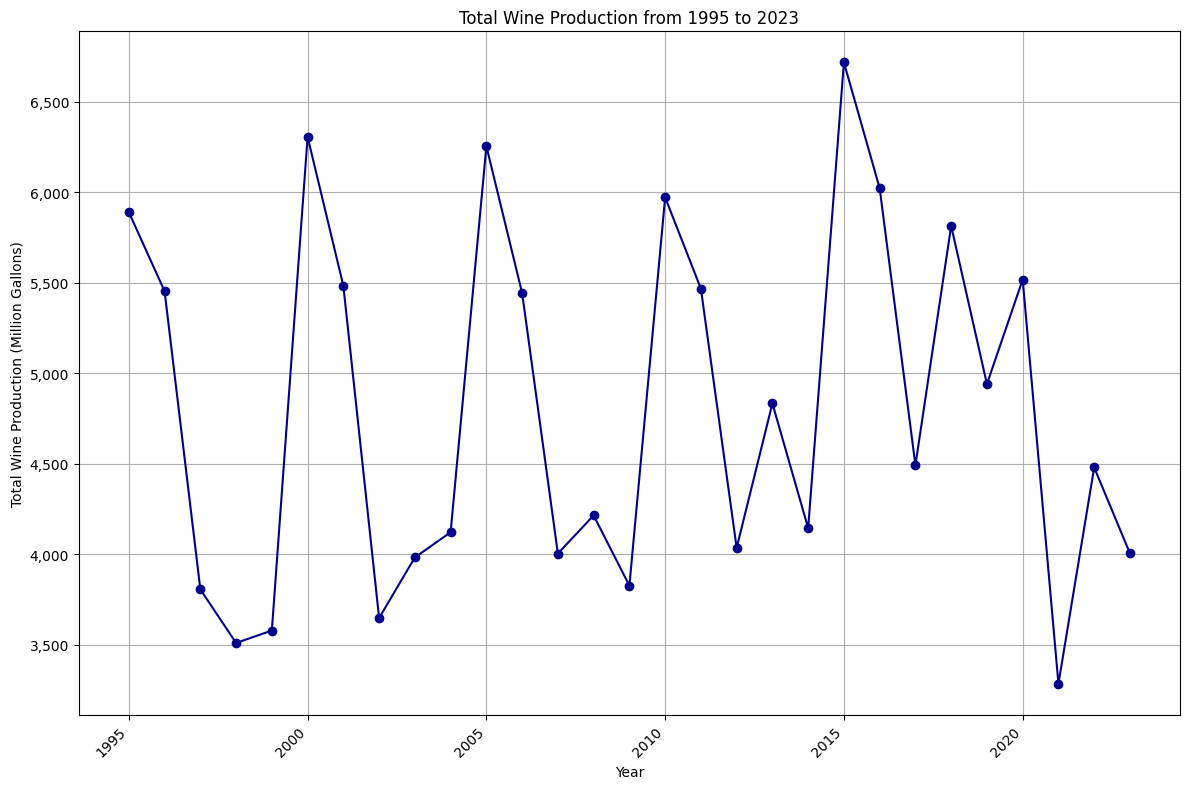

In [85]:

# Load the wine production data
wine_production_file_path = 'Resources/merged_wine_weather_for_regions_data.csv'
wine_production_df = pd.read_csv(wine_production_file_path)

# Group by Year and sum the Quantity_gallons
wine_production_by_year = wine_production_df.groupby('Year')['Gallons'].sum().reset_index()

# Convert the Quantity_gallons to millions
wine_production_by_year['Quantity_gallons_million'] = wine_production_by_year['Gallons'] / 1e6

# Define a function to format the y-axis values with thousand commas
def millions_formatter(x, pos):
    return f'{x:,.0f}'

# Convert 'Year' to just the year part and ensure it is a number
wine_production_by_year['Year'] = pd.to_numeric(wine_production_by_year['Year'].astype(str).str[:4])

# Create the line plot
plt.figure(figsize=(12, 8))
plt.plot(wine_production_by_year['Year'], wine_production_by_year['Quantity_gallons_million'], marker='o', linestyle='-', color='darkblue')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Total Wine Production (Million Gallons)')
plt.title('Total Wine Production from 1995 to 2023')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.grid(True)
plt.tight_layout()

# Rotate and align the x-axis labels
plt.xticks(rotation=45, ha='right')

plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


Map of total wine production by country in 1995

In [86]:
# Load the wine production data
wine_production_file_path = 'Resources/merged_wine_weather_for_regions_data.csv'
wine_production_df = pd.read_csv(wine_production_file_path)

# Filter the data to include only wine production records for the year 1995
wine_production_1995_df = wine_production_df[wine_production_df['Year'] == '1995-01-01']

# Group by Region/Country and sum the Quantity_gallons
wine_production_1995_by_country = wine_production_1995_df.groupby('country')['Gallons'].sum().reset_index()


# Create the choropleth map
fig = px.choropleth(
    wine_production_1995_by_country,
    locations="country",
    locationmode="country names", 
    color="Gallons",
    hover_name="country",
    color_continuous_scale=px.colors.sequential.OrRd,
    labels={'Gallons': 'Total Wine Production (Gallons)'},
    title='Total Wine Production by Country in 1995'
)

# Customize the layout
fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular'),
    margin={"r":0,"t":30,"l":0,"b":0}
)

# Show the plot
fig.show()


Map of total wine production by country in 2023

In [87]:
# Load the wine production data
wine_production_file_path = 'Resources/merged_wine_weather_for_regions_data.csv'
wine_production_df = pd.read_csv(wine_production_file_path)

# Filter the data to include only wine production records for the year 1995
wine_production_2023_df = wine_production_df[wine_production_df['Year'] == '2023-01-01']

# Group by Region/Country and sum the Quantity_gallons
wine_production_2023_by_country = wine_production_2023_df.groupby('country')['Gallons'].sum().reset_index()


# Create the choropleth map
fig = px.choropleth(
    wine_production_2023_by_country,
    locations="country",
    locationmode="country names", 
    color="Gallons",
    hover_name="country",
    color_continuous_scale=px.colors.sequential.OrRd,
    labels={'Gallons': 'Total Wine Production (Gallons)'},
    title='Total Wine Production by Country in 2023'
)

# Customize the layout
fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular'),
    margin={"r":0,"t":30,"l":0,"b":0}
)

# Show the plot
fig.show()

Which were the top wine producing countries from year 1995?


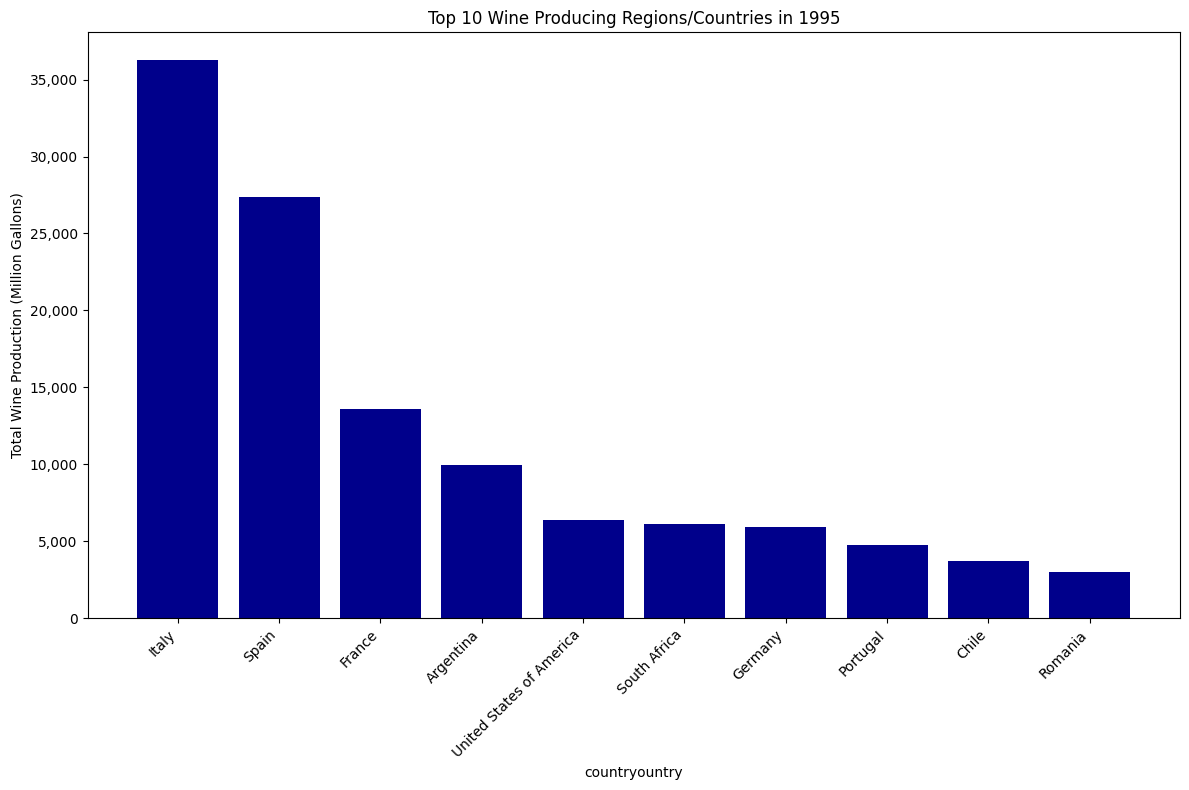

In [88]:
# Group by Region/Country and sum the Quantity_gallons
wine_production_by_region = wine_production_df.groupby('country')['Gallons'].sum().reset_index()

# Convert the Quantity_gallons to millions
wine_production_by_region['Quantity_gallons_million'] = wine_production_by_region['Gallons'] / 1e6

# Sort the values in descending order and get the top 10
top_10_wine_producing_regions = wine_production_by_region.sort_values(by='Quantity_gallons_million', ascending=False).head(10)

# Define a function to format the y-axis values with thousand commas
def millions_formatter(x, pos):
    return f'{x:,.0f}'

# Create the bar chart
plt.figure(figsize=(12, 8))
plt.bar(top_10_wine_producing_regions['country'], top_10_wine_producing_regions['Quantity_gallons_million'], color='darkblue')
plt.xlabel('countryountry')
plt.ylabel('Total Wine Production (Million Gallons)')
plt.title('Top 10 Wine Producing Regions/Countries in 1995')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.tight_layout()  # Adjust layout to make room for rotated x labels
plt.show()

Which were the top wine producing countries from year 2023?


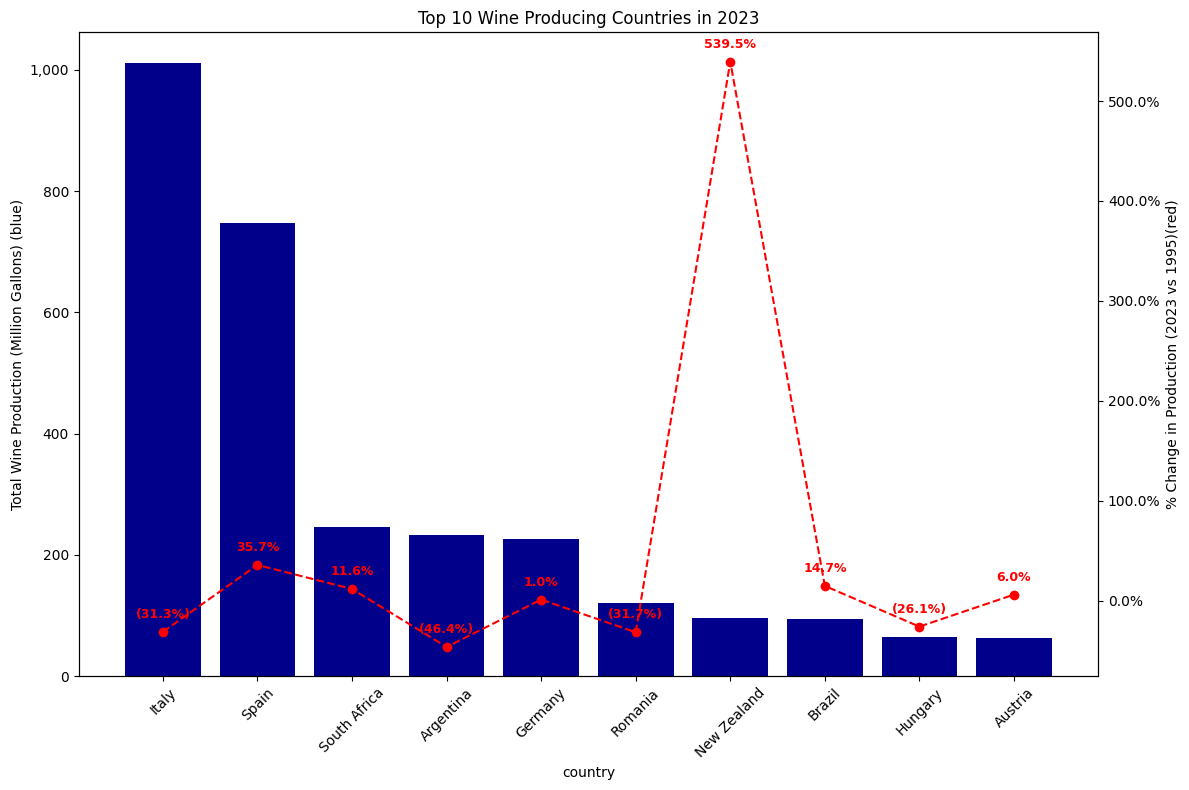

In [89]:


# Group by Region/Country and sum the Quantity_gallons for 1995 and 2023
wine_production_by_region_1995 = wine_production_1995_df.groupby('country')['Gallons'].sum().reset_index()
wine_production_by_region_2023 = wine_production_2023_df .groupby('country')['Gallons'].sum().reset_index()

# Merge the two dataframes on Region/Country
wine_production_comparison = pd.merge(wine_production_by_region_1995, wine_production_by_region_2023, on='country', suffixes=('_1995', '_2023'))

# Calculate the percentage change
wine_production_comparison['Percentage_change'] = ((wine_production_comparison['Gallons_2023'] - wine_production_comparison['Gallons_1995']) / wine_production_comparison['Gallons_1995']) * 100

# Convert the Quantity_gallons_2023 to millions for plotting
wine_production_comparison['Quantity_gallons_2023_million'] = wine_production_comparison['Gallons_2023'] / 1e6

# Sort the values in descending order and get the top 10
top_10_wine_producing_regions = wine_production_comparison.sort_values(by='Quantity_gallons_2023_million', ascending=False).head(10)

# Define a function to format the y-axis values with thousand commas
def millions_formatter(x, pos):
    return f'{x:,.0f}'

# Define a function to format the percentage change values with one decimal place
def percentage_formatter(x, pos):
    return f'{x:,.1f}%'

# Create the bar chart
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(top_10_wine_producing_regions['country'], top_10_wine_producing_regions['Quantity_gallons_2023_million'], color='darkblue')
ax1.set_xlabel('country')
ax1.set_ylabel('Total Wine Production (Million Gallons) (blue)')
ax1.set_title('Top 10 Wine Producing Countries in 2023')
ax1.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax1.tick_params(axis='x', rotation=45)

# Create the secondary axis
ax2 = ax1.twinx()
ax2.plot(top_10_wine_producing_regions['country'], top_10_wine_producing_regions['Percentage_change'], color='red', marker='o', linestyle='--')
ax2.set_ylabel('% Change in Production (2023 vs 1995)(red)')
ax2.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# Add data labels to the line graph
for i, txt in enumerate(top_10_wine_producing_regions['Percentage_change']):
    label = f'{txt:.1f}%' if txt >= 0 else f'({-txt:.1f}%)'
    ax2.annotate(label, (top_10_wine_producing_regions['country'].iloc[i], top_10_wine_producing_regions['Percentage_change'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='red', fontweight='bold')

plt.tight_layout()  # Adjust layout to make room for rotated x labels
plt.show()

# Weather by Region Analysis

In [90]:
#Region data set
file_path = 'Resources/merged_wine_weather_for_regions_data.csv'
region_data_all = pd.read_csv(file_path)

# Max temperature
# We only care about data that is not NaN
r_tmax_ww_df = region_data_all[region_data_all['TMAX_mean'].notna()]

r_tmax_ww_df.head()

,country,Year,Unit,code,Gallons,DP10_mean,DP10_std,DP1X_mean,DP1X_std,DT32_mean,...,MNPN_mean,MNPN_std,MXPN_mean,MXPN_std,PRCP_mean,PRCP_std,TAVG_mean,TAVG_std,TMAX_mean,TMAX_std
0,Albania,1995-01-01,1000 hl,AL,4464506.8,97.0,NaN,29.0,NaN,NaN,...,NaN,NaN,NaN,NaN,90.82,NaN,NaN,NaN,66.9,NaN
1,Albania,1996-01-01,1000 hl,AL,7740239.6,101.0,NaN,30.0,NaN,NaN,...,NaN,NaN,NaN,NaN,92.59,NaN,NaN,NaN,68.7,NaN
2,Albania,1997-01-01,1000 hl,AL,4438089.6,70.0,NaN,16.0,NaN,NaN,...,NaN,NaN,NaN,NaN,57.74,NaN,NaN,NaN,68.7,NaN
3,Albania,1999-01-01,1000 hl,AL,3354984.4,91.0,NaN,24.0,NaN,NaN,...,NaN,NaN,NaN,NaN,72.34,NaN,NaN,NaN,71.3,NaN
4,Albania,2000-01-01,1000 hl,AL,1954872.8,70.0,NaN,23.0,NaN,NaN,...,NaN,NaN,NaN,NaN,69.22,NaN,NaN,NaN,71.5,NaN


Dropdown(description='Country:', index=42, options=('Albania', 'Algeria', 'American Samoa', 'Argentina', 'Arme…

Dropdown(description='Weather Params:', index=2, options=('TMAX_mean', 'PRCP_mean', 'TAVG_mean', 'EMXT_mean', …

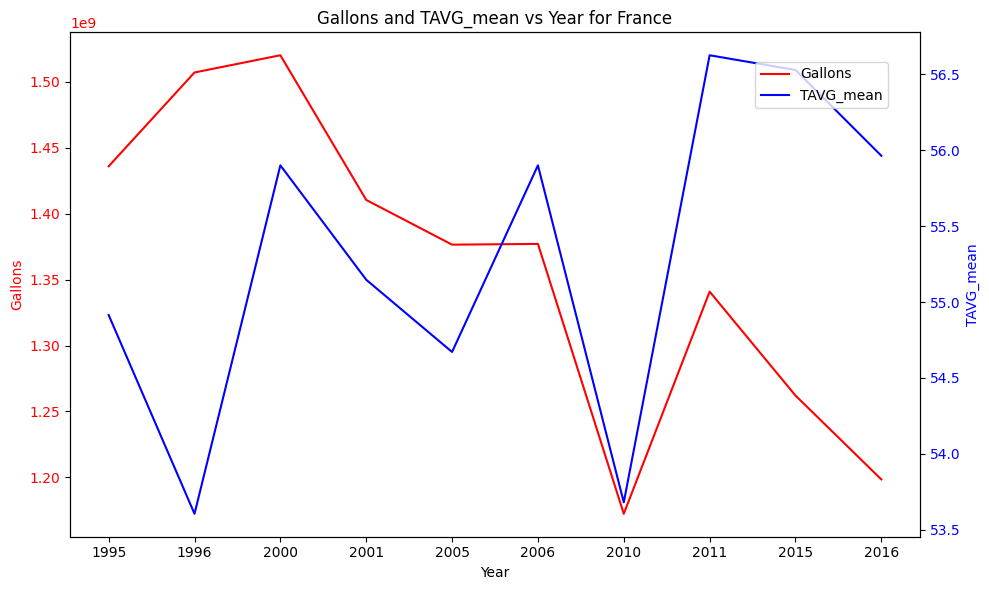

In [91]:
from IPython.display import display, clear_output


# Convert 'Year' to string format if it's not already
region_data_all['Year'] = region_data_all['Year'].astype(str).str[:4]

# Unique countries for the dropdown
countries = region_data_all['country'].unique()
weather_params = ['TMAX_mean', 'PRCP_mean', 'TAVG_mean', 'EMXT_mean', 'EMNT_mean']

# Create a dropdown widget for country selection
country_widget = widgets.Dropdown(
    options=countries,
    description='Country:',
    value='France',  # Set a default value
    disabled=False,
)

# Create a dropdown widget for weather parameters
weather_params_widget = widgets.Dropdown(
    options=weather_params,
    description='Weather Params:',
    value='TAVG_mean',  # Set a default value
    disabled=False,
)

# Function to update the plot based on the selected country
def update_plot(change=None):
    clear_output(wait=True)
    display(country_widget, weather_params_widget)

    country = country_widget.value
    weather_param = weather_params_widget.value

    # Filter the dataframe
    weather_df = region_data_all[region_data_all[weather_param].notna()]
    filtered_df = weather_df[weather_df['country'] == country]

    if filtered_df.empty:
        print(f"No data available for {country} with parameter {weather_param}")
        return

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plotting Gallons vs Year on the primary y-axis
    ax1.plot(filtered_df['Year'], filtered_df['Gallons'], color='red', label='Gallons')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Gallons', color='red')
    ax1.tick_params(axis='y', labelcolor='red')

    # Create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()
    ax2.plot(filtered_df['Year'], filtered_df[weather_param], color='blue', label=weather_param)
    ax2.set_ylabel(weather_param, color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Adding titles
    plt.title(f'Gallons and {weather_param} vs Year for {country}')

    # Adding legends
    fig.tight_layout()  # Adjust layout to fit both y-axis labels
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.show()

# Observe changes in the dropdown and update the plot accordingly
country_widget.observe(update_plot, names='value')
weather_params_widget.observe(update_plot, names='value')

# Display the widgets
display(country_widget, weather_params_widget)

# Initial plot
update_plot()
